In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime


In [60]:
class Investment:
    
    def __init__(self, ticker, amount=1000, start="2006-01-01", end="2020-01-01",drip=True):
        
        self.ticker=ticker
        self.start=start
        self.end=end
        self.drip=drip
        self.initial_investment=amount
               
        
        def download_data():
            #use download to get non-adjusted Close price data.  note that this price IS adjusted for splits. 
            #but NOT adjusted for dividends
            stock_hist = yf.download(self.ticker,interval="1mo",start=self.start, end=self.end)[['Close']].copy()
            
            #use Ticker to get dividend and split data
            div_split_hist  = yf.Ticker(self.ticker).history(interval="1mo",start=self.start, end=self.end)[['Dividends','Stock Splits']].copy()
            
            stock_data = pd.concat([stock_hist, div_split_hist],axis=1)
            stock_data['Close'].interpolate(method='time',inplace=True)
            return stock_data
        
        def calculate_tables():  #should be able to clean this up a bit. can it be done within a dataframe using loc?
            
            def split_replace_zero(split):
                if split==0:
                    split=1
                return split
            
            def fix_dividend_outlier():
                self.investment_data['Dividends'].replace(24.15,0.2415,inplace=True)
            
            #remove split adjustment from the price. Adjusts all prices before "end" date by working backwords.
            self.investment_data['True Close']    = self.investment_data['Close']*self.investment_data['Split Multiplier']
            
            prices    = self.investment_data['True Close'].values.tolist()
            dividends = self.investment_data['Dividends'].values.tolist()
            splits    = self.investment_data['Stock Splits'].values.tolist()
            
            #initialize investment state
            balance = [amount]
            shares  = [balance[0]/prices[0]]
            cash    = [0]
            
            #create an iterable and increment before entering the "for" loop
            prices_iter = iter(prices.copy())
            buyprice    = next(prices_iter)  
    
            for month,price in enumerate(prices_iter,start=1):
                total_dividend = dividends[month]*shares[month-1]
                split = splits[month-1]
                if drip:
                    newshares = total_dividend/price
                    cash.append(0)
                else:
                    newshares = 0
                    cash.append(cash[month-1]+total_dividend)  
                shares.append((shares[month-1]+newshares)*split_replace_zero(split))
                balance.append(shares[month]*price+cash[month])
                
            #these variables could be combined into a dictionary
            self.investment_data['cash'],self.investment_data['shares'],self.investment_data['balance'] = [cash,shares,balance]
                        
            fix_dividend_outlier()
            
        def split_multiplier():
            new_column=self.investment_data['Stock Splits'].replace(0,1).values[::-1].cumprod()[::-1]
            self.investment_data['Split Multiplier']=new_column
            
        
        def create_summary_table():
            gain = self.investment_data.tail(1)['balance'].values[0]/self.initial_investment
            
            date_time_start     = datetime.datetime.strptime(self.start, '%Y-%m-%d')
            date_time_end       = datetime.datetime.strptime(self.end, '%Y-%m-%d')
            investment_duration = (date_time_end-date_time_start).days/365
            
            annualized_return = gain**(1/investment_duration)-1
            
            self.summary = pd.DataFrame({"symbol":[self.ticker],"start date":[self.start],"end date":[self.end],
                                       "gain":[gain],"annualized return":[annualized_return]},
                                       columns=['symbol','start date','end date','gain','annualized return'])
                                
        
        
            
        self.investment_data=download_data()
        split_multiplier()
        calculate_tables()
        create_summary_table()
        

In [61]:
t=Investment("c",start="1996-01-01", end="2020-01-01")

[*********************100%***********************]  1 of 1 completed


In [62]:
t.summary

,symbol,start date,end date,gain,annualized return
0,c,1996-01-01,2020-01-01,1.984969,0.028959


In [63]:
t.investment_data

,Close,Dividends,Stock Splits,Split Multiplier,True Close,cash,shares,balance
Date,,,,,,,,
1996-01-01,109.583336,0.00000,0.0,0.6,65.750002,0,15.209125,1000.000000
1996-02-01,111.458336,0.00000,0.0,0.6,66.875002,0,15.209125,1017.110266
1996-02-01,111.458336,0.22494,0.0,0.6,66.875002,0,15.260282,1020.531406
1996-03-01,110.000000,0.00000,0.0,0.6,66.000000,0,15.260282,1007.178636
1996-04-01,102.500000,0.00000,0.0,0.6,61.500000,0,15.260282,938.507365
...,...,...,...,...,...,...,...,...
2019-09-01,69.080002,0.00000,0.0,1.0,69.080002,0,24.678733,1704.806934
2019-10-01,71.860001,0.00000,0.0,1.0,71.860001,0,24.678733,1773.413782
2019-11-01,75.120003,0.00000,0.0,1.0,75.120003,0,24.678733,1853.866505


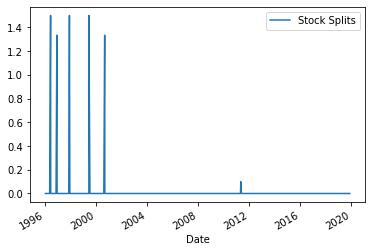

In [64]:
t.investment_data[['Stock Splits']].plot()

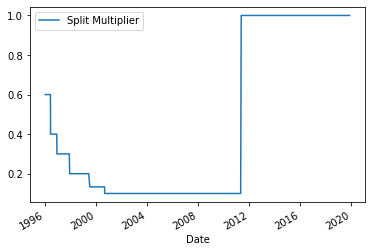

In [65]:
t.investment_data[['Split Multiplier']].plot()

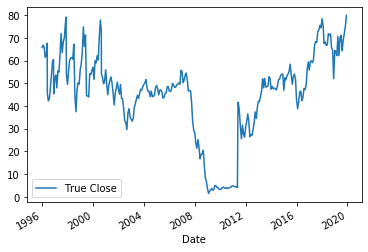

In [66]:
t.investment_data[['True Close']].plot()

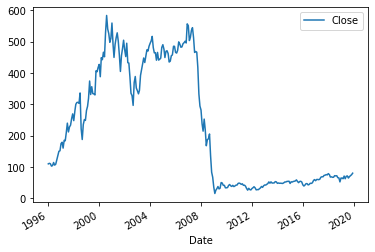

In [67]:
t.investment_data[['Close']].plot()

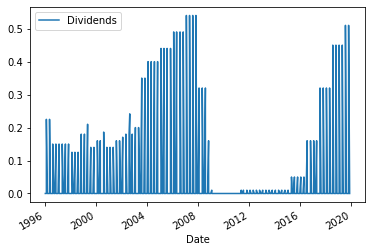

In [68]:
t.investment_data[['Dividends']].plot()

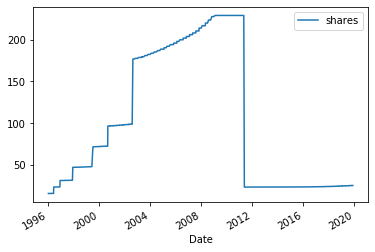

In [69]:
t.investment_data[['shares']].plot()

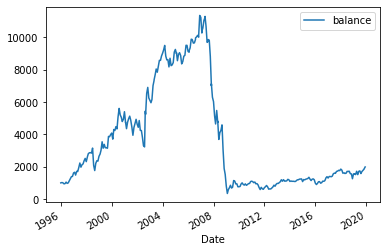

In [70]:
t.investment_data[['balance']].plot()

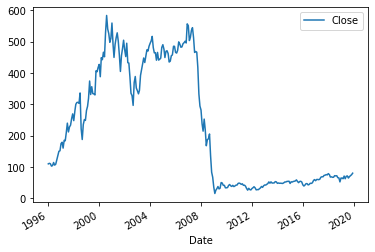

In [71]:
t.investment_data[['Close']].plot()